In [ ]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. 
# This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

In [ ]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. 
# All changes under this directory will be kept even after reset. 
# Please clean unnecessary files in time to speed up environment loading. 
!ls /home/aistudio/work

In [ ]:
# 如果需要进行持久化安装, 需要使用持久化路径, 如下方代码示例:
# If a persistence installation is required, 
# you need to use the persistence path as the following: 
!mkdir /home/aistudio/external-libraries
!pip install beautifulsoup4 -t /home/aistudio/external-libraries

In [6]:
# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可: 
# Also add the following code, 
# so that every time the environment (kernel) starts, 
# just run the following code: 
import sys 
sys.path.append('/home/aistudio/external-libraries')

# 0.导入必要的包

In [1]:
 # -*- coding:utf-8 -*-
import os 
import pickle
import random
import argparse
import platform
import numpy as np
from glob import glob
from tqdm import tqdm
import pandas as pd
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
import scipy

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 

# 1.加载数据，训练集和测试集划分

In [2]:
 # 加载训练集的pkl文件，划分训练集与验证集
ind_pkl_files = []#存放标签为0的文件
ood_pkl_files = []#存放标签为1的文件
data_path="Train"#存放数据的路径
pkl_files = glob(data_path+'/*.pkl')
for each_path in tqdm(pkl_files):
    pic = open(each_path,'rb')
    this_pkl_file= pickle.load(pic)#下载pkl文件
    if this_pkl_file[1]['label'] == '00':
        ind_pkl_files.append(each_path)
    else:
        ood_pkl_files.append(each_path)
random.seed(2022)
# 排序并打乱存放车辆序号的集合
random.shuffle(ind_pkl_files)
random.shuffle(ood_pkl_files)
# 3/4的正样本和全部的负样本作为训练集，1/4的正样本和1/4的负样本作为训练集
#train_pkl_files = [ ind_pkl_files[j] for j in range(len(ind_pkl_files)//4,len(ind_pkl_files))] + [ ood_pkl_files[i] for i in range(len(ood_pkl_files))]
train_pkl_files = [ ind_pkl_files[j] for j in range(len(ind_pkl_files)//4,len(ind_pkl_files))] + [ ood_pkl_files[i] for i in range(len(ood_pkl_files)//4,len(ood_pkl_files))]
test_pkl_files=[ind_pkl_files[i] for i in range(len(ind_pkl_files)//4)] + [ood_pkl_files[i] for i in range(len(ood_pkl_files)//4)]

100%|██████████| 28389/28389 [00:05<00:00, 4836.41it/s]


# 2.定义读取数据集及归一化函数

In [3]:
def  load_data(pkl_list,label=True):
    '''
    输入pkl的列表，进行文件加载
    label=True用来加载训练集
    label=False用来加载真正的测试集，真正的测试集无标签
    '''
    X = []
    y = []
    

    for  each_pkl in pkl_list:
        pic = open(each_pkl,'rb')
        item= pickle.load(pic)#下载pkl文件
        # 此处选取的是每个滑窗的最后一条数据，仅供参考，可以选择其他的方法，比如均值或者其他处理时序数据的网络
        # 此处选取了前7个特征，可以需求选取特征数量
        feature = item[0][:,0:7][-1]
        #feature = item[0][:,0:8][-1]
        #feature = item[0][:,0:7].mean(axis=0)
        #feature = np.append(item[0][:,0:7][-1],(item[0][:,3][-1] - item[0][:,4][-1])) #加max_single_volt - min_single_volt 一列为特征
        feature=np.append(feature,item[1]["mileage"])
        X.append(feature)
        if label:
            y.append(int(item[1]['label'][0]))
    X = np.vstack(X)
    if label:
        y = np.vstack(y)
    return X, y
    
def normalization(data,_mean,_std): 
    """
    归一化数据
    """
    data = (data - _mean) / (_std + 1e-4)
    return data

# 3.加载并归一化训练数据和验证数据

In [4]:
 # 加载并归一化训练数据和验证数据
X_train,y_train=load_data(train_pkl_files)
# 进行随机打乱，这里random_state指定为固定值，则打乱结果相同
X_train,y_train = shuffle(X_train,y_train,random_state=40)
X_test,y_test=load_data(test_pkl_files)
_mean = np.mean(X_train, axis=0)
_std = np.std(X_train, axis=0)
X_train = normalization(X_train,_mean,_std)
X_test = normalization(X_test,_mean,_std)

test1_files = glob("Test_A"+'/*.pkl')
X_val,_=load_data(test1_files,label=False)
X_val = normalization(X_val,_mean,_std)

In [2]:
!pip install imblearn
!pip install delayed     #安装后，然后重启内核，问题就解决了 


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.3/199.3 kB 5.2 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 3.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.8/24.8 MB 3.1 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.1
    Uninstalling scikit-learn-0.22.1:
      Successfully uninstalled scikit-learn-0.22.1

[notice] A new release of pip available: 22.1.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 363.0 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.2/246.2 kB 5.5 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip available: 22.1.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [5]:
# 合成负样本
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import ADASYN
import imblearn
 
X, y = make_classification(n_classes=2, class_sep=2,
                           weights=[0.1, 0.9], n_informative=3, n_redundant=1, flip_y=0,
                           n_features=20, n_clusters_per_class=1, n_samples=100,
                           random_state=10)
X = X_train[:]
y = y_train[:].squeeze()

print(imblearn.__file__)

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/imblearn/__init__.py


Original dataset shape Counter({0: 17802, 1: 3491})


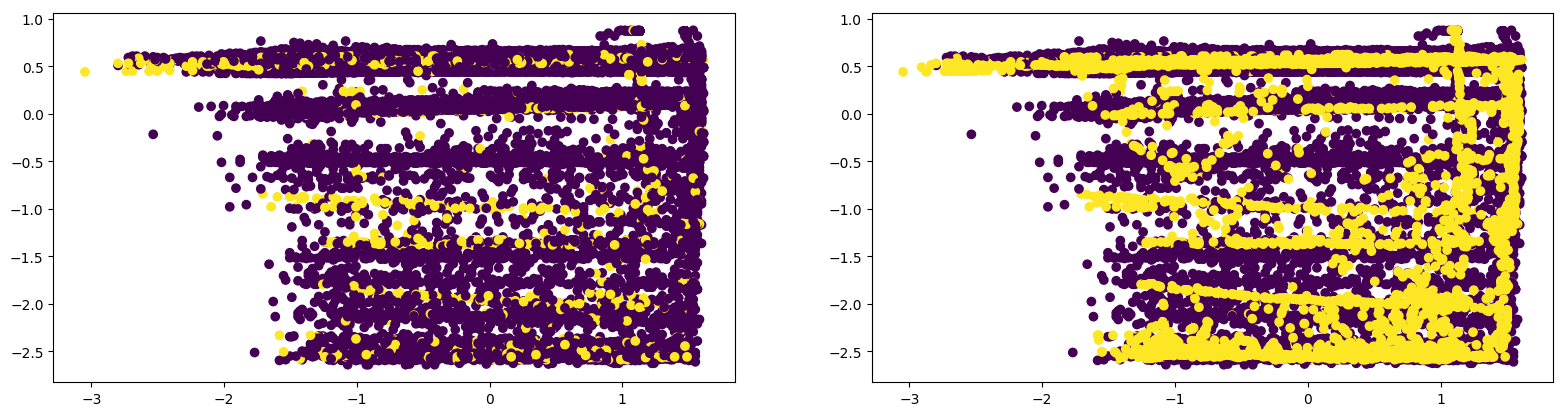

Resampled dataset shape Counter({0: 17802, 1: 7005})
(24807, 8)


In [6]:
plt.figure(figsize=(20,20))  # 创建一个10 * 10 英寸的图像
plt.subplots_adjust(bottom=.05,top=.9,left=.05,right=.8)
plt.subplot(421)
plt.scatter(X[:,0],X[:,1],marker='o',c=y)
"""
n_classes         int            可选(default = 0)    类别或者标签数量
class_sep        float           可选(default = 1.0)  乘以超立方体大小的因子。 较大的值分散了簇/类，并使分类任务更容易。默认为1
weights     floats列表 or None   可选(default = None) 每个类的权重，用于分配样本点
n_informative     int            可选 (default=2)     多信息特征数量
n_redundant       int            可选 (default=2)     冗余信息，informative特征的随机线性组合
n_features        int            可选 (default=20)    特征个数= n_informative（） + n_redundant + n_repeated
n_clusters_per_class int         可选(default=2)      每个class中cluster数量
n_samples         int            可选(default = 100)  样本数量
random_state      随机
"""

print('Original dataset shape %s' % Counter(y))
plt.subplot(422)
ada = ADASYN(sampling_strategy={1: 3491*2 },random_state=42)
X_res, y_res = ada.fit_resample(X, y)
plt.scatter(X_res[:,0],X_res[:,1],marker='o',c=y_res)
plt.show()

print('Resampled dataset shape %s' % Counter(y_res))
print(X_res.shape)
y_res = y_res.reshape(-1,1)

# 4.定义网络结构

In [5]:
import paddle
from paddle import nn


def _make_nn_module(module_type, *args):
    if isinstance(module_type, str):
        if module_type == 'ReGLU':
            return ReGLU()
        elif module_type == 'GEGLU':
            return GEGLU()
        else:
            try:
                cls = getattr(nn, module_type)
            except AttributeError as err:
                raise ValueError(
                    f'Failed to construct the module {module_type} with the arguments {args}'
                ) from err
            return cls(*args)
    else:
        return module_type(*args)

class ResNet(nn.Layer):
    """The ResNet model used in [gorishniy2021revisiting].
    The following scheme describes the architecture:
    .. code-block:: text
        ResNet: (in) -> Linear -> Block -> ... -> Block -> Head -> (out)
                 |-> Norm -> Linear -> Activation -> Dropout -> Linear -> Dropout ->|
                 |                                                                  |
         Block: (in) ------------------------------------------------------------> Add -> (out)
          Head: (in) -> Norm -> Activation -> Linear -> (out)
    Examples:
        .. testcode::
            x = torch.randn(4, 2)
            module = ResNet.make_baseline(
                d_in=x.shape[1],
                n_blocks=2,
                d_main=3,
                d_hidden=4,
                dropout_first=0.25,
                dropout_second=0.0,
                d_out=1
            )
            assert module(x).shape == (len(x), 1)
    References:
        * [gorishniy2021revisiting] Yury Gorishniy, Ivan Rubachev, Valentin Khrulkov, Artem Babenko, "Revisiting Deep Learning Models for Tabular Data", 2021
    """
    class Block(nn.Layer):
        """The main building block of `ResNet`."""

        def __init__(
            self,
            *,
            d_main,
            d_hidden,
            bias_first,
            bias_second,
            dropout_first,
            dropout_second,
            normalization,
            activation,
            skip_connection,
        ):
            super().__init__()
            self.normalization = _make_nn_module(normalization, d_main)
            self.linear_first = nn.Linear(d_main, d_hidden, bias_first)
            self.activation = _make_nn_module(activation)
            self.dropout_first = nn.Dropout(dropout_first)
            self.linear_second = nn.Linear(d_hidden, d_main, bias_second)
            self.dropout_second = nn.Dropout(dropout_second)
            self.skip_connection = skip_connection

        def forward(self, x):
            x_input = x
            x = self.normalization(x)
            x = self.linear_first(x)
            x = self.activation(x)
            x = self.dropout_first(x)
            x = self.linear_second(x)
            x = self.dropout_second(x)
            if self.skip_connection:
                x = x_input + x
            return x

    class Head(nn.Layer):
        """The final module of `ResNet`."""

        def __init__(
            self,
            *,
            d_in,
            d_out,
            bias,
            normalization,
            activation,
        ):
            super().__init__()
            self.normalization = _make_nn_module(normalization, d_in)
            self.activation = _make_nn_module(activation)
            self.linear = nn.Linear(d_in, d_out, bias)

        def forward(self, x):
            if self.normalization is not None:
                x = self.normalization(x)
            x = self.activation(x)
            x = self.linear(x)
            return x

    def __init__(
        self,
        *,
        d_in,
        n_blocks,
        d_main,
        d_hidden,
        dropout_first,
        dropout_second,
        normalization,
        activation,
        d_out: int,
    ) -> None:
        """
        Note:
            `make_baseline` is the recommended constructor.
        """
        super().__init__()

        self.first_layer = nn.Linear(d_in, d_main)
        if d_main is None:
            d_main = d_in
        self.blocks = nn.Sequential(
            *[
                ResNet.Block(
                    d_main=d_main,
                    d_hidden=d_hidden,
                    bias_first=True,
                    bias_second=True,
                    dropout_first=dropout_first,
                    dropout_second=dropout_second,
                    normalization=normalization,
                    activation=activation,
                    skip_connection=True,
                )
                for _ in range(n_blocks)
            ]
        )
        self.head = ResNet.Head(
            d_in=d_main,
            d_out=d_out,
            bias=True,
            normalization=normalization,
            activation=activation,
        )

    @classmethod
    def make_baseline(
        cls,
        *,
        d_in,
        n_blocks,
        d_main,
        d_hidden,
        dropout_first,
        dropout_second,
        d_out,
    ) -> 'ResNet':
        """Create a "baseline" `ResNet`.
        This variation of ResNet was used in [gorishniy2021revisiting]. Features:
        * :code:`Activation` = :code:`ReLU`
        * :code:`Norm` = :code:`BatchNorm1d`
        Args:
            d_in: the input size
            n_blocks: the number of Blocks
            d_main: the input size (or, equivalently, the output size) of each Block
            d_hidden: the output size of the first linear layer in each Block
            dropout_first: the dropout rate of the first dropout layer in each Block.
            dropout_second: the dropout rate of the second dropout layer in each Block.
        References:
            * [gorishniy2021revisiting] Yury Gorishniy, Ivan Rubachev, Valentin Khrulkov, Artem Babenko, "Revisiting Deep Learning Models for Tabular Data", 2021
        """
        return cls(
            d_in=d_in,
            n_blocks=n_blocks,
            d_main=d_main,
            d_hidden=d_hidden,
            dropout_first=dropout_first,
            dropout_second=dropout_second,
            normalization='BatchNorm1D',
            activation='ReLU',
            d_out=d_out,
        )

    def forward(self, x):
        x = self.first_layer(x)
        x = self.blocks(x)
        x = self.head(x)
        return x


In [6]:
class PyODDataset(paddle.io.Dataset):

    def __init__(self, X, y):
        super(PyODDataset, self).__init__()
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        sample = self.X[idx, :]
        label = self.y[idx,:]

        return paddle.to_tensor(sample,dtype="float32"), paddle.to_tensor(label,dtype="float32")

class Loss(paddle.nn.Layer):

   def forward(self, inputs, labels):
       #return paddle.nn.functional.mse_loss(input=input.squeeze(), label=label.squeeze())
       #return  paddle.nn.loss.CrossEntropyLoss(inputs.squeeze(), labels.squeeze())
       return  paddle.nn.functional.binary_cross_entropy_with_logits(inputs.squeeze(), labels.squeeze())
       #return  paddle.nn.functional.sigmoid_focal_loss(inputs.squeeze(), labels.squeeze())



def evaluate(X_test, y_test, pos_label=1):
        y_scores = scipy.special.expit(model(paddle.to_tensor(X_test,dtype="float32")).numpy())
        aucroc = roc_auc_score(y_true=y_test, y_score=y_scores)
        aucpr = average_precision_score(y_true=y_test, y_score=y_scores, pos_label=1)
        metric = {'aucroc': aucroc, 'aucpr': aucpr}
        return y_scores,metric['aucpr']

In [7]:
# 早停法
# 当测试指标7次不下降的时候停止
class EarlyStopping:
   
    def __init__(self, patience=7, verbose=False, delta=0.00001, path='weight7-stop.pth', trace_func=print):
       
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
    def save_checkpoint(self, val_loss, model):
        '''Saves model when val_metric decrease.'''
        if self.verbose:
            self.trace_func(f'val_metric  decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        paddle.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score
import warnings
warnings.filterwarnings("ignore")
model = ResNet.make_baseline(
                d_in=8,
                d_main=128,
                d_hidden=256,
                dropout_first=0.25,
                dropout_second=0.0,
                n_blocks=8,
                d_out=1,
            )
model.train()
train_dataset=PyODDataset(X_train,y_train) # 正负样例{0: 17802, 1: 3491}
#train_dataset=PyODDataset(X_res,y_res)   # 正负样例1:1
train_loader = paddle.io.DataLoader(train_dataset, places=paddle.CPUPlace(), batch_size=256, shuffle=True, num_workers=0)
test_dataset=PyODDataset(X_test,y_test) 
test_loader = paddle.io.DataLoader(test_dataset, places=paddle.CPUPlace(), batch_size=8, shuffle=False, num_workers=0)
losspsnr = Loss()
max_epoch=532
#scheduler = paddle.optimizer.lr.CosineAnnealingDecay(learning_rate=0.001, T_max=max_epoch)
#opt = paddle.optimizer.AdamW(learning_rate=scheduler, parameters=model.parameters())  
opt = paddle.optimizer.AdamW(learning_rate=0.001, parameters=model.parameters())  
now_step=0
import time
train_loss = []
val_loss = []
early_stopping = EarlyStopping()
for epoch in range(max_epoch):
    epoch_loss = []
    val_epoch_loss = []
    model.train()
    for step, data in enumerate(train_loader):
        now_step+=1
        img, label = data
        pre = model(img)
        # print(pre)
        # print(label)
        loss = losspsnr(pre,label)
        epoch_loss.append(loss.item())
        loss.backward()
        opt.step()
        opt.clear_gradients()
    loss_ep = sum(epoch_loss)/len(epoch_loss)
    train_loss.append(loss_ep)
   
    #==========================每次进行完一个训练迭代，就去测试一把看看此时的效果==========================
    # 在测试集上检验效果
    model.eval()  # 将模型改为预测模式
    # 每次迭代都是处理一个小批量的数据，batch_size是1
    for step, data in enumerate(test_loader):
        img, label = data
        pre = model(img)
        loss1 = losspsnr(pre,label)
        val_loss.append(loss1.item())
    eval_loss = sum(val_loss)/len(val_loss)
    _, val_metric = evaluate(X_train, y_train)
    print(f'Epoch {epoch:03d} |loss is: {loss_ep:.4f} | Validation metric: {val_metric:.4f}')
    # 早停止
    early_stopping(eval_loss, model)
    #达到早停止条件时，early_stop会被置为True
    if early_stopping.early_stop:
        print("Early stopping")
        break #跳出迭代，结束训练 

Epoch 000 |loss is: 0.2534 | Validation metric: 0.8593
Epoch 001 |loss is: 0.1708 | Validation metric: 0.9332
Epoch 002 |loss is: 0.1439 | Validation metric: 0.9343
Epoch 003 |loss is: 0.1254 | Validation metric: 0.9585
Epoch 004 |loss is: 0.1179 | Validation metric: 0.9572
Epoch 005 |loss is: 0.1101 | Validation metric: 0.9575
Epoch 006 |loss is: 0.0998 | Validation metric: 0.9740
Epoch 007 |loss is: 0.0947 | Validation metric: 0.9765
Epoch 008 |loss is: 0.0999 | Validation metric: 0.9787
Epoch 009 |loss is: 0.1022 | Validation metric: 0.9811
Epoch 010 |loss is: 0.0928 | Validation metric: 0.9820
Epoch 011 |loss is: 0.0833 | Validation metric: 0.9496
EarlyStopping counter: 1 out of 7
Epoch 012 |loss is: 0.0858 | Validation metric: 0.9834
Epoch 013 |loss is: 0.0793 | Validation metric: 0.9837
Epoch 014 |loss is: 0.0840 | Validation metric: 0.9868
Epoch 015 |loss is: 0.0826 | Validation metric: 0.9885
Epoch 016 |loss is: 0.0795 | Validation metric: 0.9789
Epoch 017 |loss is: 0.0725 | Va

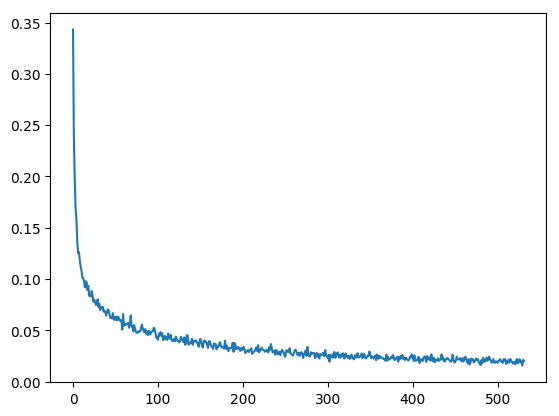

In [11]:
from matplotlib import pyplot as plt
plt.plot(train_loss)
plt.plot(eval_loss)
plt.show()

In [12]:
# metric
def metric(y_test=None,y_score=None):
    aucroc = roc_auc_score(y_true=y_test, y_score=y_score)
    aucpr = average_precision_score(y_true=y_test, y_score=y_score, pos_label=1)
    metric = {'aucroc': aucroc, 'aucpr': aucpr}
    return metric
y_val_scores = scipy.special.expit(model(paddle.to_tensor(X_test,dtype="float32")).numpy())
metric(y_test=y_test, y_score=y_val_scores)
# {'aucroc': 0.998381757658137, 'aucpr': 0.9974851335369507} 532
# {'aucroc': 0.9990453732486252, 'aucpr': 0.9967391300437867} 归一化使用训练的均值和方差
# {'aucroc': 0.999602975560135, 'aucpr': 0.9968868241913524}  使用ADASYN进行扩增负样本1:1
# {'aucroc': 0.9994064560710102, 'aucpr': 0.9956533955303498} 使用ADASYN进行扩增负样本的2倍


{'aucroc': 0.9994064560710102, 'aucpr': 0.9956533955303498}

In [13]:
import paddle
import platform

# model = ResNet.make_baseline(
#                 d_in=8,
#                 d_main=128,
#                 d_hidden=256,
#                 dropout_first=0.25,
#                 dropout_second=0.0,
#                 n_blocks=2,
#                 d_out=1,
#             )
# param_dict = paddle.load("model_500.pdparams")
# model.load_dict(param_dict)
model.eval()
y_val_scores = scipy.special.expit(model(paddle.to_tensor(X_val,dtype="float32")).numpy())
#y_val_scores = clf.predict_score(X_val)   #返回未知数据上的异常值 (分值越大越异常) # outlier scores
#记录文件名和对应的异常得分
predict_result={}
for i in tqdm(range(len(test1_files))):
    file=test1_files[i]
    #如果是window系统：
    if platform.system().lower() == 'windows':
        name=file.split('\\')[-1]
    #如果是linux系统
    elif platform.system().lower() == 'linux':
        name=file.split('/')[-1]
    predict_result[name]=y_val_scores[i].item()
predict_score=pd.DataFrame(list(predict_result.items()),columns=['file_name','score'])#列名必须为这俩个
predict_score.to_csv(f'submision.csv',index = False) #保存为比赛要求的csv文件




100%|██████████| 6234/6234 [00:00<00:00, 534665.69it/s]


In [12]:
from sklearn.metrics import roc_auc_score, average_precision_score
# metric
def metric(y_true=y_true,y_score=y_val_scores):
    aucroc = roc_auc_score(y_true=y_test, y_score=y_scores)
    aucpr = average_precision_score(y_true=y_test, y_score=y_scores, pos_label=1)
    metric = {'aucroc': aucroc, 'aucpr': aucpr}
    return metric
y_val_scores = scipy.special.expit(model(paddle.to_tensor(X_test,dtype="float32")).numpy())
metric(y_true=y_test, y_score=y_val_scores)

(7096, 1)
(7096, 1)


{'aucroc': 0.9993860939853008, 'aucpr': 0.9971181276682515}

In [ ]:
# {'aucroc': 0.9997775387789039, 'aucpr': 0.9988731246736042}  更换损失函数 mse ---> binary_cross_entropy_with_logits,性能由0.7783提升至0.8477
# {'aucroc': 0.9994405861150285, 'aucpr': 0.9976666291990668}  重新划分数据集，和0.8477对应
# {'aucroc': 0.9996401490475688, 'aucpr': 0.9983206436327146}  更换sigmoid_focal_loss
# {'aucroc': 0.999304210864832, 'aucpr': 0.9967131627984829}   adamw      2个节点
# {'aucroc': 0.9983121932372079, 'aucpr': 0.9923940554002263}  #增加负样例，532，2个节点
# {'aucroc': 0.9993860939853008, 'aucpr': 0.9971181276682515}  #不增加负样例，532，2个节点
# {'aucroc': 0.9995218895319894, 'aucpr': 0.9982133270692795}  16个节点

In [ ]:
def predict_score(self, X):
    X = torch.from_numpy(X).float().to(self.device)
    score, _ = self.evaluate(X=X, y=None)
    return score
 

def evaluate(self, X, y=None):
    model.eval()
    score = []
    # for batch in delu.iter_batches(X[part], 1024):
    for batch in delu.iter_batches(X, self.batch_size):
        score.append(self.apply_model(batch))
    score = torch.cat(score).squeeze(1).cpu().numpy()
    score = scipy.special.expit(score)

    # calculate the metric
    if y is not None:
        target = y.cpu().numpy()
        metric = self.utils.metric(y_true=target, y_score=score)
    else:
        metric = {'aucroc': None, 'aucpr': None}

    return score, metric['aucpr']
 
 import platform
y_val_scores = clf.predict_score(X_val)   #返回未知数据上的异常值 (分值越大越异常) # outlier scores
#记录文件名和对应的异常得分
predict_result={}
for i in tqdm(range(len(test1_files))):
    file=test1_files[i]
    #如果是window系统：
    if platform.system().lower() == 'windows':
        name=file.split('\\')[-1]
    #如果是linux系统
    elif platform.system().lower() == 'linux':
        name=file.split('/')[-1]
    predict_result[name]=y_val_scores[i]
predict_score=pd.DataFrame(list(predict_result.items()),columns=['file_name','score'])#列名必须为这俩个
predict_score.to_csv(f'submision.csv',index = False) #保存为比赛要求的csv文件


array([[0.4992444 ],
       [0.50157475],
       [0.5049575 ],
       ...,
       [0.4980949 ],
       [0.71890724],
       [0.6785846 ]], dtype=float32)

In [30]:
def evaluate(label,score):
    fpr, tpr, thresholds = metrics.roc_curve(label, score, pos_label=1)
    AUC = auc(fpr, tpr)
    return AUC